In [34]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트 
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 전이 학습 (Transfer learning)
    - 어떤 목적을 이루기 위해 학습된 모델을 다른 작업에 이용하는 것 
        - 구체적으로 설명하면, 비슷한 유형의 문제를 처리한 DNN 모델이 존재하는 경우, 그 신경망의 하위층을 재사용할 수 있음.
        - 이 방법은 훈련속도를 크게 높일 뿐 아니라 필요한 훈련데이터도 크게 줄여줄 수 있음.
        - 작은 데이터셋에서의 overfitting을 예방할 수 있음.
![](./tl1.PNG)
![](./tl2.PNG)

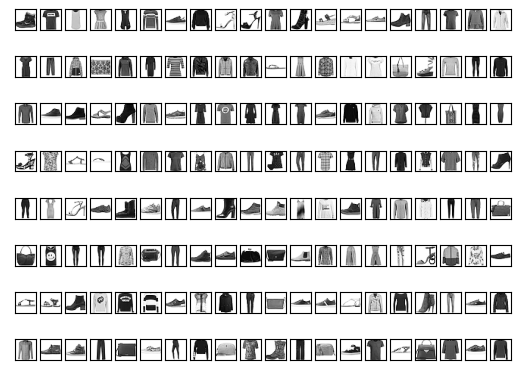

In [74]:
# Fashion MNIST : MNIST와 형태가 정확히 같지만 손글씨 숫자가 아니라 패션 아이템을 나타내는 이미지 데이터셋
import matplotlib.pyplot as plt
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

fig, axes = plt.subplots(nrows=8, ncols=20)
ax = axes.ravel()

for i in range(160):
    image = x_train[i]
    ax[i].imshow(image, cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [73]:
y_train_full[:30]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4], dtype=uint8)

In [4]:
# 패션 MNIST 훈련세트를 두개의 데이터로 나누어보면, 
# A training dataset : 샌달과 셔츠(클래스 5와6)를 제외한 모든 이미지
# B training dataset : 샌달과 셔츠 이미지 중 처음 200개

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [5]:
X_train_A.shape

(43986, 28, 28)

In [6]:
X_train_B.shape

(200, 28, 28)

In [7]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [8]:
y_train_B[:30] # binary type

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [87]:
tf.random.set_seed(42)
np.random.seed(42)

In [88]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [89]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [90]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.5594 - accuracy: 0.8245 - val_loss: 0.3901 - val_accuracy: 0.8660
Epoch 2/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3580 - accuracy: 0.8746 - val_loss: 0.3315 - val_accuracy: 0.8839
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3226 - accuracy: 0.8866 - val_loss: 0.3049 - val_accuracy: 0.8906
Epoch 4/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3026 - accuracy: 0.8956 - val_loss: 0.2908 - val_accuracy: 0.9001
Epoch 5/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.2890 - accuracy: 0.9002 - val_loss: 0.2797 - val_accuracy: 0.9046
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2783 - accuracy: 0.9043 - val_loss: 0.2744 - val_accuracy: 0.9058
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2697 - accuracy: 0.9072 - val_loss: 0.2756 - val_accuracy:

In [91]:
# model_A.save("my_model_A.h5")

In [92]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [93]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [94]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 39ms/step - loss: 0.4421 - accuracy: 0.8400 - val_loss: 0.4099 - val_accuracy: 0.8590
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3499 - accuracy: 0.8900 - val_loss: 0.3422 - val_accuracy: 0.8915
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2845 - accuracy: 0.9100 - val_loss: 0.2956 - val_accuracy: 0.9047
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2405 - accuracy: 0.9550 - val_loss: 0.2584 - val_accuracy: 0.9229
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2057 - accuracy: 0.9650 - val_loss: 0.2315 - val_accuracy: 0.9310
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.1797 - accuracy: 0.9750 - val_loss: 0.2107 - val_accuracy: 0.9422
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.1600 - accuracy: 0.9850 - val_loss: 0.1943 - val_accuracy: 0.9473
Epoch 8/20
7/7 [===========

In [95]:
# model_A에서 출력층을 제외한 모든층 재사용
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # 출력층 제외
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [96]:
model_A_clone = keras.models.clone_model(model_A) # model_A와 model_B_on_A는 층이 공유됨으로 영향을 받지 않고자 한다면 재사용 전 복제
model_A_clone.set_weights(model_A.get_weights()) # 가중치 복사 / clone_model은 가중치를 복사하지 않음.
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) # 출력층 제외
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [97]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # 재사용된 층을 동결 처리 (재사용된 가중치의 크기를 유지하면서 오차를 줄이는 방법)

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 41ms/step - loss: 1.3448 - accuracy: 0.4000 - val_loss: 1.2553 - val_accuracy: 0.4483
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 1.2492 - accuracy: 0.4250 - val_loss: 1.1767 - val_accuracy: 0.4767
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 1.1668 - accuracy: 0.4600 - val_loss: 1.1041 - val_accuracy: 0.5000
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 1.0907 - accuracy: 0.4700 - val_loss: 1.0333 - val_accuracy: 0.5243


In [98]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True # 동결 처리 해제 (새롭게 적용한 모델에 대한 세밀한 튜닝) -> Fine tuning

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 39ms/step - loss: 0.7590 - accuracy: 0.5550 - val_loss: 0.4793 - val_accuracy: 0.7667
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4188 - accuracy: 0.8050 - val_loss: 0.3536 - val_accuracy: 0.8519
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.3051 - accuracy: 0.8700 - val_loss: 0.2748 - val_accuracy: 0.9026
Epoch 4/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2341 - accuracy: 0.9200 - val_loss: 0.2241 - val_accuracy: 0.9270
Epoch 5/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1878 - accuracy: 0.9500 - val_loss: 0.1892 - val_accuracy: 0.9422
Epoch 6/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1550 - accuracy: 0.9600 - val_loss: 0.1654 - val_accuracy: 0.9533
Epoch 7/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1328 - accuracy: 0.9750 - val_loss: 0.1488 - val_accuracy: 0.9584
Epoch 8/16
7/7 [===========

In [99]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9790


[0.09872356057167053, 0.9789999723434448]

In [100]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9890


[0.07530523836612701, 0.9890000224113464]

In [101]:
(100 - 97.89) / (100 - 98.90)

1.9181818181818275

### 비지도 사전훈련 (unsupervised pretraining)
    - 레이블된 훈련 데이터가 많지 않을경우, 레이블이 안된 훈련 데이터를 이용하여 오토인코더(autoencoder)나 GAN와 같은 비지도 학습모델로 훈련한 후,
    - 레이블된 훈련 데이터로 지도학습 모델로 최종학습을 하도록 함.
![](./unsuper1.PNG)

### 보조작업에서 사전훈련
    - 레이블된 훈련데이터가 많지 않다면 마지막 선택사항은 레이블된 훈련데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에서 첫번째 신경망을 훈련하는 것


### 고속 옵티마이저
    - 훈련속도를 높일 수 있는 방법의 한가지로 표준적인 확률적 경사하강법(Stochastic Gradient descent) 대신 더 빠른 옵티마이저를 사용할 수 있음
    - 모멘텀 최적화(momentum optimization), 네스테로프 가속 경사 (Nesterov accelerate gradient), AdaGrad, RMSProp, Adam, Nadam 

- 경사하강법의 한계
    + Local Minimum에 빠지기 쉽다는 점
    + Saddle point(안장점)를 벗어나지 못한다는 점
   
    reference : https://heytech.tistory.com/382

![](./images_minjung-s_post_affe546c-e6f3-4697-8717-336e69090b9f_optimization.gif)

##### 1. 모멘텀 최적화
    - 모멘텀 벡터(m)를 사용하여 가중치(theta)를 최적화하는 방법, 이전 step에서의 기울기를 고려한 알고리즘, 기울기 방향으로 힘을 받아 물체가 가속된다는 물리법칙으로 이해할 수 있음
    - 새로운 파라메터인 모멘텀(beta)은 0 ~ 1사이에서 설정되어야 하며 일반적으로 0.9를 사용함.
    - overshooting의 문제 : 경사가 가빠른 곳에서 모멘텀 벡터(가속도)가 커짐으로 인해 최소지점을 지나쳐 버리는 문제가 발생할 수 있음.

![](./opt1.PNG)

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

##### 2. 네스테로프 가속 경사
    - 모멘텀 최적화의 변종, 네스테로프 모멘텀 최적화라고도 함.
    - theta의 그레이디언트가 아닌 theta + (beta*m)에서의 그레이디언트를 계산함. 현재 위치가 아닌 모멘텀의 방향으로 조금 앞선 곳에서 비용함수의 그레이디언트를 계산함.
    - 모멘텀 최적화보다 속도도 빠르고 정확도도 높음. overshooting 해결
![](./opt2.PNG)

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

##### 3. AdaGrad (Adaptive Gradient)
    - 각각의 매개변수에 대해 스케일을 조정한다는 점이 경사하강법(가중치에 대한 비용함수의 그레이디언트에 학습률을 곱한 것을 차감하여 가중치를 갱신)과의 차이점임.
    - 학습률(learning rate)을 감소시키지만, 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소함.(adaptive learning rate, 적응적 학습률)
    - 그레이디언트 제곱을 벡터 s에 누적하고 s + epsilon 의 루트값으로 나누어 스케일을 조정함.
![](./opt3.PNG)

In [21]:
optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)

g:\내 드라이브\ai_handson\ai_handson1\lib\site-packages\keras\optimizers\optimizer_v2\adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


##### 4. RMSProp
    - AdaGarad 는 학습률이 급격히 감소하여 global optimizer에 수렴하지 못하는 위험이 있음.
    - 가장 최근 반복에서 비롯된 그레이디언트만 누적함으로써 문제 해결, 지수이동평균
    - 감쇠율(beta)는 0.9로 설정함. 일밙적으로 기본값이 잘 작동함으로 튜닝할 필요는 없음.
![](./opt4.PNG)

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

##### 5. Adam (Adaptive moment estimation, 적응적 모멘텀 추정)
    - 모멘텀 최적화와 RMSPop의 아이디어를 합친 것임.
    - 보통 beta1 은 0.9, beta2는 0.999 로 설정함.
![](./opt51.PNG)
![](./opt52.PNG)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [69]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

optimizers = ['SGD','momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam']
out = pd.DataFrame()

for opt in optimizers :
    rst = []
    if opt == 'SGD' :
        model_B.compile(loss="binary_crossentropy",
                    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                    metrics=["accuracy"])
    if opt == 'momentum' :
        model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                metrics=["accuracy"])
    if opt == 'nesterov' :
        model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6),
                metrics=["accuracy"])
    if opt == 'adagrad' :
        model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6),
                metrics=["accuracy"])
    if opt == 'rmsprop' :
        model_B.compile(loss="binary_crossentropy",
                optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
                metrics=["accuracy"])           
    if opt == 'adam' :
        model_B.compile(loss="binary_crossentropy",
                optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
                metrics=["accuracy"])           
    
    history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
    rst = pd.DataFrame(model_B.evaluate(X_test_B, y_test_B))
    out = pd.concat([out, pd.concat([rst.iloc[0], rst.iloc[1]], axis=0)], axis=1)
out.index = ['loss', 'accuracy']
out.columns = optimizers
out

Epoch 1/20
7/7 [==============================] - 1s 35ms/step - loss: 0.8063 - accuracy: 0.5050 - val_loss: 0.5971 - val_accuracy: 0.6542
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.5663 - accuracy: 0.7250 - val_loss: 0.4540 - val_accuracy: 0.7901
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.4335 - accuracy: 0.8150 - val_loss: 0.3666 - val_accuracy: 0.8773
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3515 - accuracy: 0.8650 - val_loss: 0.3089 - val_accuracy: 0.9108
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2948 - accuracy: 0.9050 - val_loss: 0.2676 - val_accuracy: 0.9361
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2519 - accuracy: 0.9300 - val_loss: 0.2369 - val_accuracy: 0.9462
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2216 - accuracy: 0.9450 - val_loss: 0.2136 - val_accuracy: 0.9574
Epoch 8/20
7/7 [===========

g:\내 드라이브\ai_handson\ai_handson1\lib\site-packages\keras\optimizers\optimizer_v2\adagrad.py:81: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 1s 36ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9929
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9929
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9929
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9929
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 0.9929
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9929
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9919
Epoch 8/20
7/7 [======================

,SGD,momentum,nesterov,adagrad,rmsprop,adam
loss,0.104864,0.026516,0.020323,0.019379,0.032797,0.041194
accuracy,0.980500,0.991000,0.993000,0.994000,0.994000,0.995000


##### reference
    - https://twinw.tistory.com/247
    - https://heytech.tistory.com/383
    - https://velog.io/@cha-suyeon/DL-%EC%B5%9C%EC%A0%81%ED%99%94-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98#41-%ED%99%95%EB%A5%A0%EC%A0%81-%EA%B2%BD%EC%82%AC-%ED%95%98%EA%B0%95%EB%B2%95stochastic-gradient-descent
    - https://kdeon.tistory.com/55